<div style="text-align: center;">
  <img src="images/op.webp" alt="OP" width="25%">
</div>

Grupo:
- Daniel Nobre de Queiroz Pereira
- Georg Herison Maia Nunes
- Yves Pablo Costa Rêgo

# Atividade Avaliativa Unidade 1

**Descrição:**
Neste notebook, vamos construir o pipeline de PLN para análise de sentimento dos arcos de One Piece utilizando um dataset em **inglês**. Cobriremos desde a coleta e organização dos textos dos capítulos, até o pré-processamento e extração de features. A modelagem e avaliação dos modelos ficarão para a Atividade 2.

**Objetivos da Atividade 1:**
1. Coletar e organizar os datasets (textos dos capítulos em inglês).  
2. Executar limpeza e pré-processamento (tokenização, remoção de stopwords, normalização) adaptados para inglês.  
3. Extrair features (Bag-of-Words, TF–IDF).  
4. Realizar Análise Exploratória de Dados (EDA) e conclusões iniciais.

## Coleta e organização do dataset

O dataset utilizado foi coletado utilizando OCR para extrair o texto dos capítulos do mangá. Inicialmente, apenas os 100 primeiros capítulos (cerca de 10% do total) foram utilizados.


Os dados foram organizados da seguinte forma:

```
One_Piece/
├── Chapter 1 Romance Dawn - The Dawn of the Adventure _July 19 1997_ 53/
│   └── texts/
│       ├── 01.txt
│       ├── 02.txt
│       ├── 03.txt
│       └── ...
├── Chapter 2 That Guy, "Straw Hat Luffy" _August 4 1997_ 45/
│   └── texts/
│       ├── 01.txt
│       ├── 02.txt
│       ├── 03.txt
│       └── ...
└── ...
```
Com 01.txt, 02.txt [...] representando o texto contido em uma página do capítulo.

## 1. Setup do ambiente

Nesta seção, importamos as bibliotecas necessárias e configuramos o ambiente para rodar nosso pipeline.

In [250]:
# Bibliotecas para manipulação de dados e texto
import os
import re
import pandas as pd
import numpy as np

# Biblioteca de tokenização e stopwords
import nltk


# Biblioteca para extração de features
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Para visualizações iniciais
import matplotlib.pyplot as plt

# Garantir downloads de recursos NLTK
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\neope\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\neope\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\neope\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Carregar Dados

Carregamos todos os arquivos de texto dos capítulos em um DataFrame.

In [292]:
import os
import re
import pandas as pd

# Caminho para o diretório base
base_path = 'One_Piece'

# Listas para armazenar dados
arcos = []
capitulos = []
nomes_arquivos = []
conteudos = []

# Percorrer todos os diretórios e subdiretórios
for root, dirs, files in os.walk(base_path):
    if 'texts' in dirs:
        texts_path = os.path.join(root, 'texts')
        
        for txt_file in sorted(os.listdir(texts_path)):
            if txt_file.endswith('.txt'):
                file_path = os.path.join(texts_path, txt_file)
                
                with open(file_path, 'r', encoding='utf-8') as f:
                    content = f.read().replace('\n', ' ').strip()
                    
                # Pegar nome do arco e do capítulo
                arc_name = os.path.basename(os.path.dirname(root))  # pasta acima de texts
                chapter_name = os.path.basename(root)  # pasta que contém 'texts'

                # Armazenar dados
                arcos.append(arc_name)
                capitulos.append(chapter_name)
                nomes_arquivos.append(txt_file)
                conteudos.append(content)

# Criar o DataFrame
df = pd.DataFrame({
    'arc': arcos,
    'chapter': capitulos,
    'file': nomes_arquivos,
    'text': conteudos
})

print(df.head())



               arc                                            chapter    file  \
0  01 Romance Dawn  Chapter 1 Romance Dawn - The Dawn of the Adven...  01.txt   
1  01 Romance Dawn  Chapter 1 Romance Dawn - The Dawn of the Adven...  02.txt   
2  01 Romance Dawn  Chapter 1 Romance Dawn - The Dawn of the Adven...  03.txt   
3  01 Romance Dawn  Chapter 1 Romance Dawn - The Dawn of the Adven...  04.txt   
4  01 Romance Dawn  Chapter 1 Romance Dawn - The Dawn of the Adven...  05.txt   

                                                text  
0  ONEPIECE AB EHCHIRO ODA ROMANCE DAWN- JUMP COM...  
1  ROMANCE DAWN ElICHIRO ODA JUMP COMICS ONEPIECE...  
2  CHAPTER7"FRIEND' CHAPTER6FIRST PERSON CHAPTER8...  
3  HIS LAST WORDS BEFORE HIS EXECUTION HAVE INSPI...  
4  MAGES EDITTED BY AOSH TRANSLATION BY JIN-ROH A...  


## 3. Pré-processamento

Limpeza básica do texto em inglês: minúsculas, remoção de pontuação/números, tokenização e remoção de stopwords.

In [447]:
import re
import requests
import pandas as pd
from nltk.tokenize import word_tokenize

# Configurações compartilhadas
STOPWORDS_URL = "https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt"
NOISE_WORDS = {'onepiecg', 'oda', 'isbnc', 'eiichiro', 'nbn', 'sbs', 'japan', 'tcbscans'}
NOISE_REGEX = r'\b(?:' + '|'.join(re.escape(word) for word in NOISE_WORDS) + r')\b'
MANGA_SITES_REGEX = r'(?:manga(?:re(?:ader)?|panda|dex|kakalot|nelo)|readmanganato|patreon|webtoon)(?:\.(?:com|net|org|xyz|br))?\b'
DOMAINS_REGEX = r'\b(?:[a-z0-9-]+\.)+(?:com|net|org|xyz|br)\b'
CHAPTER_REGEX = r'\bchapter[\w-]*'

def load_stopwords():
    """Carrega stopwords"""
    stopwords_content = requests.get(STOPWORDS_URL).content
    sw = set(stopwords_content.decode().splitlines())
    sw.update(NOISE_WORDS)
    return sw

# Carrega stopwords (singleton)
STOPWORDS = load_stopwords()

def shared_preprocessing(text, lowercase=False):
    """Processamento compartilhado entre ambas as funções"""
    if not isinstance(text, str):
        return "" if lowercase else []
    
    processed = text.lower() if lowercase else text
    
    # Aplicar todas as substituições regex compartilhadas
    regex_substitutions = [
        (r'\S+@\S+', ''),  # Emails
        (r'https?://\S+', ''),  # URLs
        (MANGA_SITES_REGEX, ''),  
        (DOMAINS_REGEX, ''),  
        (CHAPTER_REGEX, ''),  # Capítulos
        (NOISE_REGEX, '')
    ]
    
    for pattern, replacement in regex_substitutions:
        processed = re.sub(pattern, replacement, processed, flags=re.IGNORECASE)
    
    return processed

def preprocess_eda(text):
    """Pré-processamento para análise exploratória"""
    processed = shared_preprocessing(text, lowercase=True)
    
    # Etapas específicas do EDA
    processed = re.sub(r"[^a-z\s]", "", processed)  # Somente letras
    tokens = word_tokenize(processed, language='english')
    tokens = [t for t in tokens if t not in STOPWORDS and len(t) > 1]
    
    return tokens

def preprocess_bert(text):
    """Pré-processamento para BERT/transformers"""
    processed = shared_preprocessing(text)
    
    # Etapas específicas do BERT
    processed = re.sub(r'\s+', ' ', processed).strip()
    return processed


# Aplicando os pré-processamentos
df['tokens'] = df['text'].apply(preprocess_eda)  # Para EDA (tokenização)
df['clean_text'] = df['text'].apply(preprocess_bert)  # Para BERT/transformers
df[['chapter', 'tokens']]


,chapter,tokens
0,Chapter 1 Romance Dawn - The Dawn of the Adven...,"[onepiece, ehchiro, romance, dawn, jump, comic..."
1,Chapter 1 Romance Dawn - The Dawn of the Adven...,"[romance, dawn, elichiro, jump, comics, onepie..."
2,Chapter 1 Romance Dawn - The Dawn of the Adven...,"[friend, person, nami, enters, romance, dawn, ..."
3,Chapter 1 Romance Dawn - The Dawn of the Adven...,"[execution, inspired, pirates, entered, pirate..."
4,Chapter 1 Romance Dawn - The Dawn of the Adven...,"[mages, editted, aosh, translation, jinroh, ao..."
...,...,...
19438,Chapter 999 The Sake I Brewed to Drink With Yo...,"[charging, complete, idont, care, killbut, lea..."
19439,Chapter 999 The Sake I Brewed to Drink With Yo...,"[stil, asa, brother, owe, life, long, debt, ka..."
19440,Chapter 999 The Sake I Brewed to Drink With Yo...,"[readers, weare, magazine, cleaners, urgently,..."
19441,Chapter 999 The Sake I Brewed to Drink With Yo...,"[kaidos, tattoo, lives, island, atop, gigantic..."


## 4. Extração de Features

Criamos representações Bag-of-Words e TF–IDF.

In [448]:
df['clean_text_eda'] = df['tokens'].apply(lambda tokens: ' '.join(tokens))

count_vec = CountVectorizer()
X_counts = count_vec.fit_transform(df['clean_text_eda'])
print(f"Bag-of-Words shape: {X_counts.shape}")

tfidf_vec = TfidfVectorizer()
X_tfidf = tfidf_vec.fit_transform(df['clean_text_eda'])
print(f"TF–IDF shape: {X_tfidf.shape}")

Bag-of-Words shape: (19443, 104867)
TF–IDF shape: (19443, 104867)


## 5. Análise Exploratória de Dados (EDA)

### 5.1 Tamanho dos textos (número de palavras)








In [449]:
df['text_length'] = df['tokens'].apply(len)

### Estatísticas descritivas

In [450]:
print(df['text_length'].describe())


count    19443.000000
mean        24.712184
std         17.183267
min          0.000000
25%         12.000000
50%         22.000000
75%         35.000000
max        276.000000
Name: text_length, dtype: float64


### Histograma da distribuição do tamanho dos textos

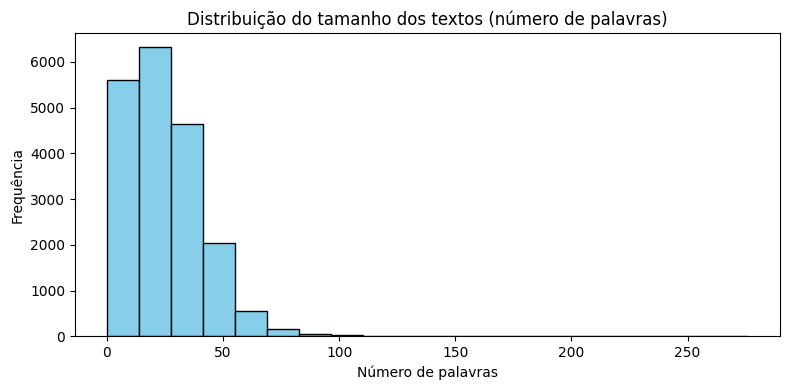

In [451]:
plt.figure(figsize=(8, 4))
plt.hist(df['text_length'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribuição do tamanho dos textos (número de palavras)')
plt.xlabel('Número de palavras')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()

### 📊 Análise Univariada

**Distribuição do Tamanho dos Textos**

O histograma da distribuição do número de palavras por trecho mostra que a maioria dos textos possui entre 5 e 30 palavras. Há um pico de frequência entre 20 e 25 palavras, o que sugere que esse é o tamanho mais comum dos trechos extraídos. O formato assimétrico à direita (distribuição enviesada positivamente) indica que há poucos textos com um número muito alto de palavras, possivelmente resultantes de páginas com maior densidade de diálogos ou descrições.

### 📌 Estatísticas descritivas relevantes:

Média de palavras por trecho: entre 20 e 25

Desvio padrão estimado: relativamente moderado

Assimetria positiva: cauda mais longa à direita

### 5.2 Número de palavras únicas por capítulo

In [454]:
df['unique_words'] = df['tokens'].apply(lambda x: len(set(x)))

### Dispersão: tamanho do texto vs. palavras únicas

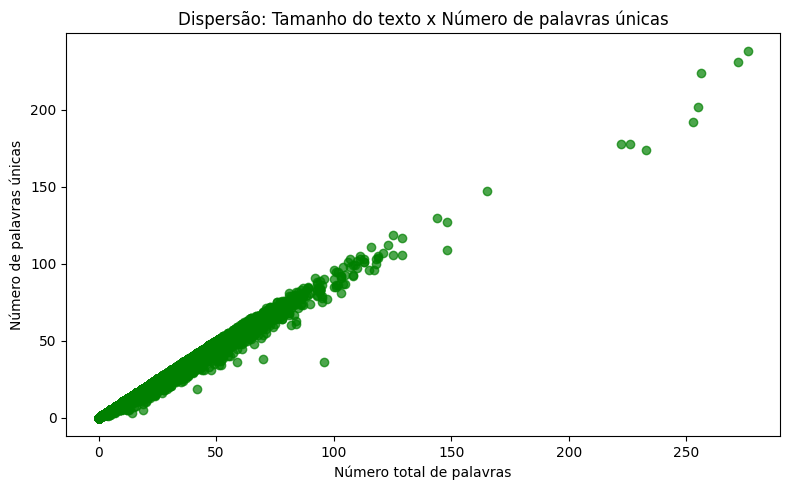

In [453]:
plt.figure(figsize=(8, 5))
plt.scatter(df['text_length'], df['unique_words'], alpha=0.7, color='green')
plt.title('Dispersão: Tamanho do texto x Número de palavras únicas')
plt.xlabel('Número total de palavras')
plt.ylabel('Número de palavras únicas')
plt.tight_layout()
plt.show()

### Correlação

In [455]:
correlation = df[['text_length', 'unique_words']].corr()
print("Correlação entre tamanho do texto e número de palavras únicas:")
print(correlation)

Correlação entre tamanho do texto e número de palavras únicas:
              text_length  unique_words
text_length      1.000000      0.993442
unique_words     0.993442      1.000000


### 🔍 Análise Bivariada

**Relação entre Número Total de Palavras e Palavras Únicas**

O gráfico de dispersão mostra uma relação fortemente linear entre o número total de palavras e o número de palavras únicas por texto. Isso indica que, conforme o tamanho do texto aumenta, há um crescimento proporcional na diversidade lexical (riqueza de vocabulário).

No entanto, observa-se que essa diversidade tende a se estabilizar levemente em textos maiores, sugerindo repetição de termos comuns em falas mais longas.

### 📌 Interpretação:

- Correlação positiva forte (visual) entre comprimento e diversidade de palavras.

- Textos curtos apresentam pouca diversidade, como esperado.

- Textos com mais de 50 palavras não aumentam proporcionalmente a quantidade de palavras únicas, indicando possível redundância lexical.

### 5.3 Termos mais frequentes

In [456]:
freq = np.array(X_counts.sum(axis=0)).flatten()
terms = count_vec.get_feature_names_out()
freq_df = pd.DataFrame({'term': terms, 'frequency': freq})
freq_df = freq_df.sort_values(by='frequency', ascending=False).head(20)

freq_df

,term,frequency
20660,dont,2788
39759,iii,2194
44071,island,1619
51932,luffy,1507
77407,ship,1354
67677,pirates,1312
89750,time,1301
41189,ill,1262
67641,pirate,1216
63541,onepiece,1211


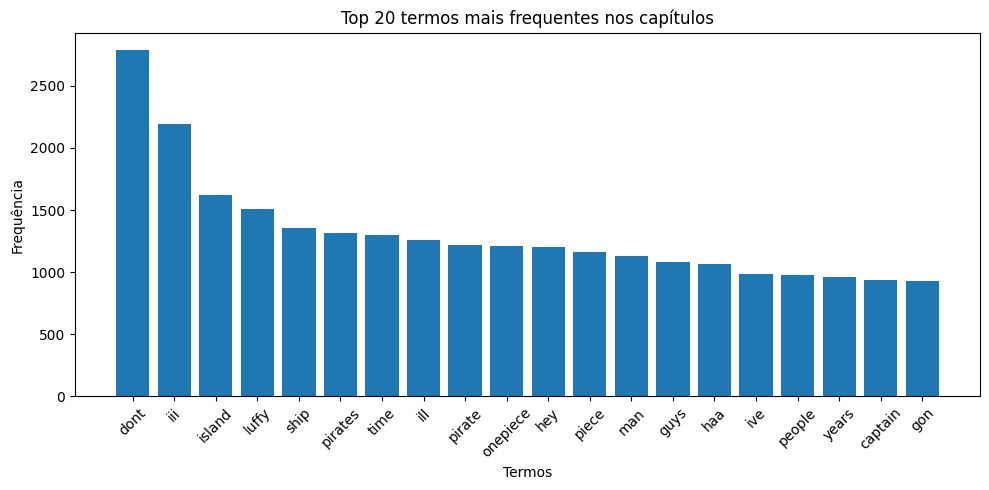

In [457]:
plt.figure(figsize=(10,5))
plt.bar(freq_df['term'], freq_df['frequency'])
plt.xticks(rotation=45)
plt.title('Top 20 termos mais frequentes nos capítulos')
plt.ylabel('Frequência')
plt.xlabel('Termos')
plt.tight_layout()
plt.show()

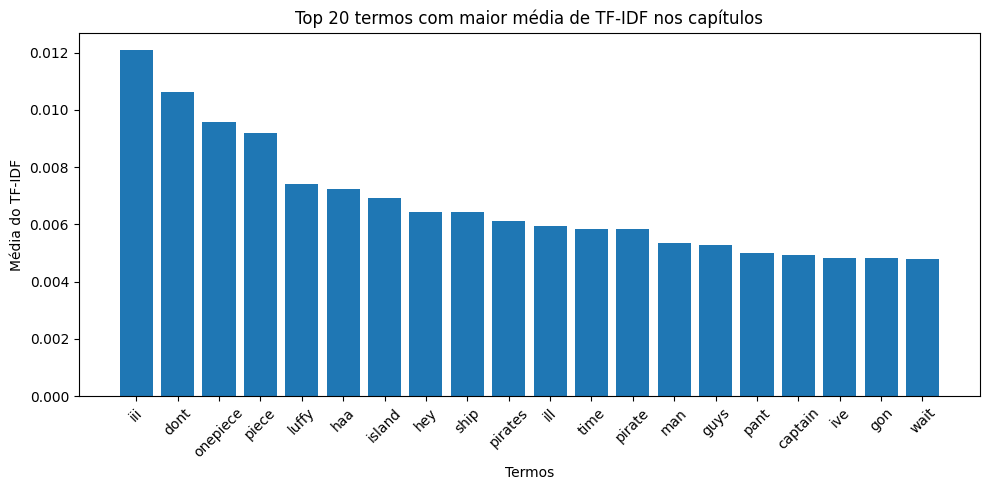

In [458]:
# Calcular média do TF-IDF por termo
tfidf_means = np.array(X_tfidf.mean(axis=0)).flatten()
terms_tfidf = tfidf_vec.get_feature_names_out()

# Criar DataFrame com os termos e suas médias de TF-IDF
tfidf_df = pd.DataFrame({'term': terms_tfidf, 'tfidf': tfidf_means})
tfidf_df = tfidf_df.sort_values(by='tfidf', ascending=False).head(20)

# Visualização
plt.figure(figsize=(10, 5))
plt.bar(tfidf_df['term'], tfidf_df['tfidf'])
plt.xticks(rotation=45)
plt.title('Top 20 termos com maior média de TF-IDF nos capítulos')
plt.ylabel('Média do TF-IDF')
plt.xlabel('Termos')
plt.tight_layout()
plt.show()


# Conclusões iniciais e interpretação preliminar
Em nossa análise inicial, após o pré-processamento, observamos que nomes de personagens e expressões em inglês características do mangá aparecem entre os mais frequentes.

Além disso, analisamos a frequência de palavras em 4 situações:
1. **Sem remoção de stopwords**  
   ![Gráfico sem remoção de stopwords](images/no_stopwords.jpeg)  
   As palavras mais frequentes eram comuns ao inglês — *"you"*, *"the"*, *"that"*.

2. **Com remoção de stopwords usando NLTK**  
   ![Gráfico com stopwords padrão do NLTK](images/default_stopwords.jpeg)  
   Começaram a aparecer termos mais relacionados ao conteúdo, como *"pirates"* e *"captain"*.

3. **Com remoção de mais stopwords (lista do GitHub)**  
   ![Gráfico com lista estendida de stopwords](images/more_stopwords.jpeg)  
   Os termos estavam mais ligados ao domínio, mostrando nomes de personagens (*"Zoro"*, *"Luffy"*, *"Nami"*) e reduzindo palavras erroneamente escritas em inglês.

4. **Com stopwords do GitHub + remoções customizadas**  
   ![Gráfico com lista estendida de stopwords](images/4.png)  
   Os termos ficaram mais limpos com a inclusão de algumas palavras-chave como stopwords (como "onepieceg").

Apesar disso, nota-se que as stopwords incluem termos como "not" e "don't", que podem alterar o significado das frases.


Os achados sugerem que a linguagem utilizada nos capítulos segue uma estrutura repetitiva com vocabulário limitado em trechos curtos (condizente com balões de fala). A proporção de palavras únicas aumenta inicialmente, mas tende a estabilizar à medida que o tamanho do texto cresce, o que é comum em narrativas com linguagem informal ou diálogo intenso.

Essas observações abrem espaço para futuras análises, como:

- Detecção de personagens pela frequência de termos específicos.

- Evolução do vocabulário ao longo dos capítulos.


Na próxima etapa, segmentaremos por arcos (ex.: capítulos 1–61 para East Blue) e exploraremos a rotulação.

---
**Próximos passos (Atividade 2):**
- Definir rótulos de sentimento
- Treinar modelos de classificação de sentimento
- Avaliar e comparar resultados entre os arcos narrativos

Teste

In [430]:
print(df.head())

               arc                                            chapter    file  \
0  01 Romance Dawn  Chapter 1 Romance Dawn - The Dawn of the Adven...  01.txt   
1  01 Romance Dawn  Chapter 1 Romance Dawn - The Dawn of the Adven...  02.txt   
2  01 Romance Dawn  Chapter 1 Romance Dawn - The Dawn of the Adven...  03.txt   
3  01 Romance Dawn  Chapter 1 Romance Dawn - The Dawn of the Adven...  04.txt   
4  01 Romance Dawn  Chapter 1 Romance Dawn - The Dawn of the Adven...  05.txt   

                                                text  \
0  ONEPIECE AB EHCHIRO ODA ROMANCE DAWN- JUMP COM...   
1  ROMANCE DAWN ElICHIRO ODA JUMP COMICS ONEPIECE...   
2  CHAPTER7"FRIEND' CHAPTER6FIRST PERSON CHAPTER8...   
3  HIS LAST WORDS BEFORE HIS EXECUTION HAVE INSPI...   
4  MAGES EDITTED BY AOSH TRANSLATION BY JIN-ROH A...   

                                              tokens  \
0  [onepiece, ehchiro, romance, dawn, jump, comic...   
1  [romance, dawn, elichiro, jump, comics, onepie...   
2  [frie

In [459]:
from transformers import pipeline
import torch
from tqdm import tqdm
import pandas as pd
import numpy as np

# Pipeline de emoções
device = 0 if torch.cuda.is_available() else -1
emotion_pipeline = pipeline("text-classification", 
                            model="bhadresh-savani/bert-base-uncased-emotion", 
                            return_all_scores=True, 
                            device=device)

arc_num = 0
# Filtra para pegar só os capítulos do primeiro arco
primeiro_arco = df['arc'].iloc[arc_num]  # Pega o nome do primeiro arco
# Filtra o dataframe para pegar só o primeiro arco inteiro
df_primeiro_arco = df[df['arc'] == df['arc'].unique()[arc_num]]

# Função auxiliar para dividir o texto
def split_text(text, max_length=512):
    return [text[i:i+max_length] for i in range(0, len(text), max_length)]

# Análise por capítulo do arco inteiro (sem limitar a 70)
emotion_results = []


for idx, row in tqdm(df_primeiro_arco.iterrows(), total=len(df_primeiro_arco), desc="Analisando emoções por capítulo"):
    pages = split_text(row['clean_text'])  # Dividir texto em blocos
    all_scores = []

    for page in pages:
        scores = emotion_pipeline(page)
        emotion_scores = {item['label']: item['score'] for item in scores[0]}
        all_scores.append(emotion_scores)

    # Calcula média das emoções por capítulo
    avg_scores = pd.DataFrame(all_scores).mean().to_dict()
    emotion_results.append(avg_scores)

# DataFrame com emoções agregadas por capítulo do arco inteiro
emotion_df = pd.DataFrame(emotion_results)
df_emotion = pd.concat([df_primeiro_arco[['arc', 'chapter']], emotion_df], axis=1)


Device set to use cuda:0
c:\Users\neope\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Analisando emoções por capítulo: 100%|██████████| 181/181 [00:02<00:00, 87.83it/s]


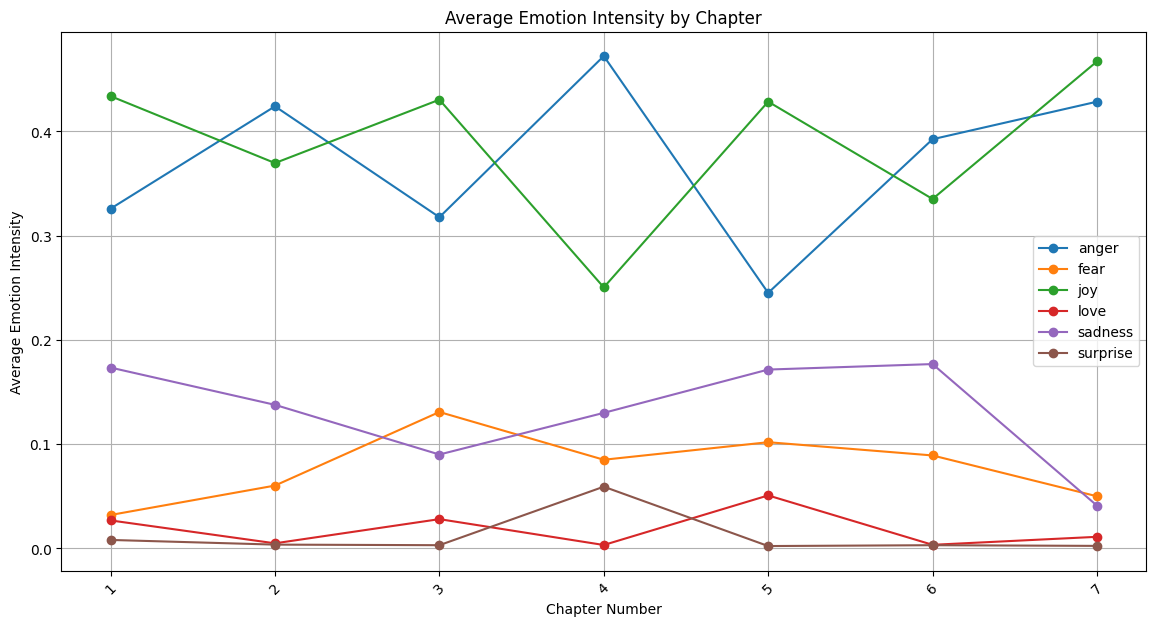

In [460]:


import matplotlib.pyplot as plt

# Assumindo que seu df_emotion tem as colunas: ['chapter', 'arc', 'anger', 'joy', 'sadness', ...]

# 1. Agrupar por capítulo e calcular a média das emoções
emotion_labels = df_emotion.columns.difference(['chapter', 'arc'])
df_grouped = df_emotion.groupby('chapter')[emotion_labels].mean().reset_index()

# Extrai números dos capítulos (considerando formatos como "Chapter X" ou números puros)
def extract_chapter_number(ch):
    if isinstance(ch, str):
        if 'Chapter' in ch:
            num_part = ch.split(' ')[1]
            return int(num_part) if num_part.isdigit() else np.inf
        return int(ch) if ch.isdigit() else np.inf
    return int(ch)

df_grouped['chapter_num'] = df_grouped['chapter'].apply(extract_chapter_number)
df_grouped = df_grouped.sort_values('chapter_num')

plt.figure(figsize=(14,7))

# 2. Plotar as emoções médias por capítulo
for emotion in emotion_labels:
    plt.plot(df_grouped['chapter'], df_grouped[emotion], marker='o', label=emotion)

plt.xlabel('Chapter Number')
plt.ylabel('Average Emotion Intensity')
plt.title('Average Emotion Intensity by Chapter')
plt.legend()
plt.grid(True)

# Se quiser formatar o eixo x para mostrar só o número do capítulo, sem strings longas:
chapter_nums = [ch.split(' ')[1] if len(ch.split(' ')) > 1 else ch for ch in df_grouped['chapter']]

plt.xticks(df_grouped['chapter'], chapter_nums, rotation=45)

plt.show()

In [461]:
from transformers import pipeline
import torch
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Configuração do modelo de emoções
device = 0 if torch.cuda.is_available() else -1
emotion_pipeline = pipeline("text-classification", 
                          model="bhadresh-savani/bert-base-uncased-emotion", 
                          return_all_scores=True, 
                          device=device,
                          torch_dtype=torch.float16 if device == 0 else torch.float32,  # Usar mixed precision na GPU
                          truncation=True,
                          padding=True,
                          batch_size=8 if device == 0 else 1  # Processamento em batch na GPU
                          )

# 2. Função para análise emocional por arco
def analyze_arc_emotions(df, max_arcs=None):
    def split_text(text, max_length=500):
        return [text[i:i+max_length] for i in range(0, len(text), max_length)]
    
    all_arcs = df['arc'].unique()
    if max_arcs is not None:
        all_arcs = all_arcs[:max_arcs]
    
    arc_emotion_results = {}
    
    for arc in tqdm(all_arcs, desc="Analisando arcos"):
        df_arc = df[df['arc'] == arc]
        chapter_emotion_results = []
        
        # Processar textos em batch
        all_pages = []
        for _, row in df_arc.iterrows():
            all_pages.extend(split_text(row['clean_text']))
        
        # Processar em lotes para melhor desempenho
        batch_size = 8 if device == 0 else 1
        for i in range(0, len(all_pages), batch_size):
            batch = all_pages[i:i+batch_size]
            try:
                batch_scores = emotion_pipeline(batch)
                for scores in batch_scores:
                    chapter_emotion_results.append({item['label']: item['score'] for item in scores})
            except Exception as e:
                # Fallback para processamento individual em caso de erro
                for page in batch:
                    scores = emotion_pipeline(page)
                    chapter_emotion_results.append({item['label']: item['score'] for item in scores[0]})
                    
        if chapter_emotion_results:
            # Agregação 
            arc_avg_scores = {
                emotion: np.mean([chap[emotion] for chap in chapter_emotion_results])
                for emotion in chapter_emotion_results[0].keys()
            }
            arc_emotion_results[arc] = arc_avg_scores
    
    df_arc_emotions = pd.DataFrame.from_dict(arc_emotion_results, orient='index')
    df_arc_emotions = df_arc_emotions.reset_index().rename(columns={'index': 'arc'})
    df_arc_emotions['dominant_emotion'] = df_arc_emotions.drop('arc', axis=1).idxmax(axis=1)
    
    return df_arc_emotions

# 3. Executar a análise (substitua 'df' pelo seu DataFrame)
df_arc_emotions = analyze_arc_emotions(df, max_arcs=31)  # Teste com 3 arcos



Device set to use cuda:0
c:\Users\neope\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Analisando arcos: 100%|██████████| 31/31 [00:49<00:00,  1.59s/it]


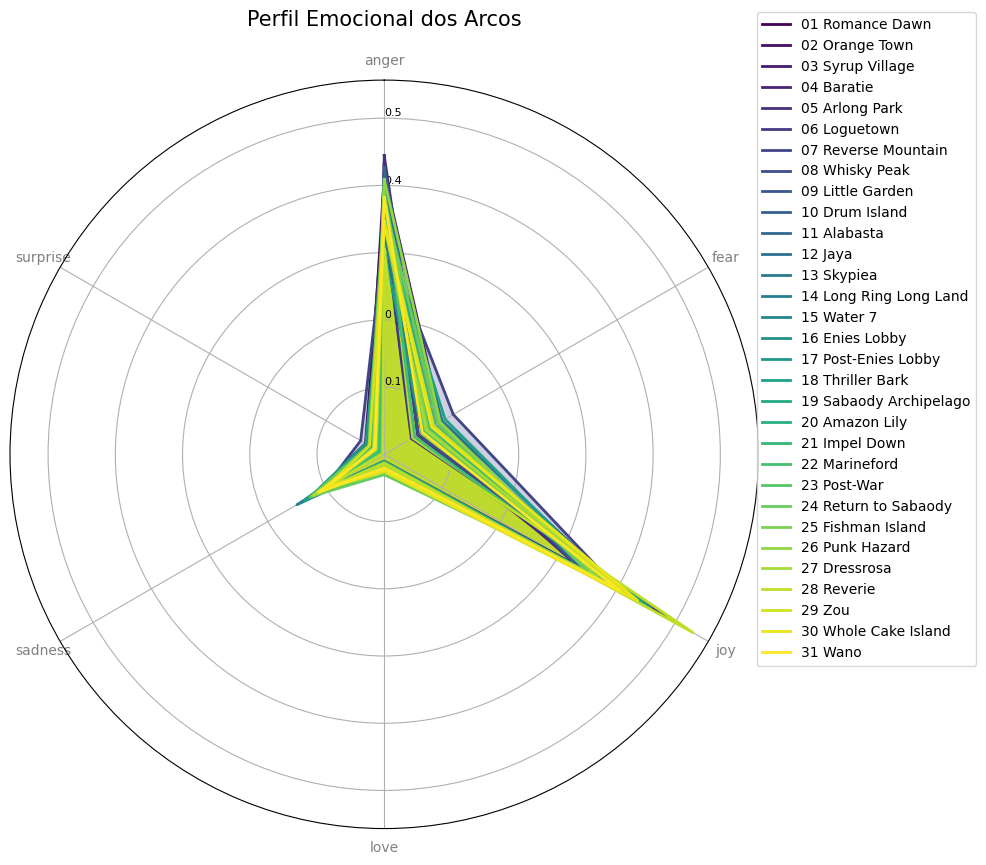

In [462]:
import numpy as np
from math import pi

# Versão corrigida do gráfico de radar
def plot_radar_comparativo(df, emotion_labels):
    # Configurações
    categories = emotion_labels
    N = len(categories)
    
    # Ângulos para os eixos
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # Fechar o círculo
    
    # Inicializar figura
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111, polar=True)
    
    # Fixar a primeira variável no topo
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    # Plotar cada arco
    colors = plt.cm.viridis(np.linspace(0, 1, len(df)))
    for idx, row in df.iterrows():
        values = row[emotion_labels].tolist()
        values += values[:1]  # Fechar o gráfico
        ax.plot(angles, values, color=colors[idx], linewidth=2, label=row['arc'])
        ax.fill(angles, values, color=colors[idx], alpha=0.25)
    
    # Configurações do eixo
    plt.xticks(angles[:-1], categories, color='grey', size=10)
    ax.tick_params(axis='y', labelsize=8)
    ax.set_rlabel_position(0)
    
    # Legenda e título
    plt.title('Perfil Emocional dos Arcos', size=15, pad=20)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()

# Uso:
plot_radar_comparativo(df_arc_emotions, emotion_labels)

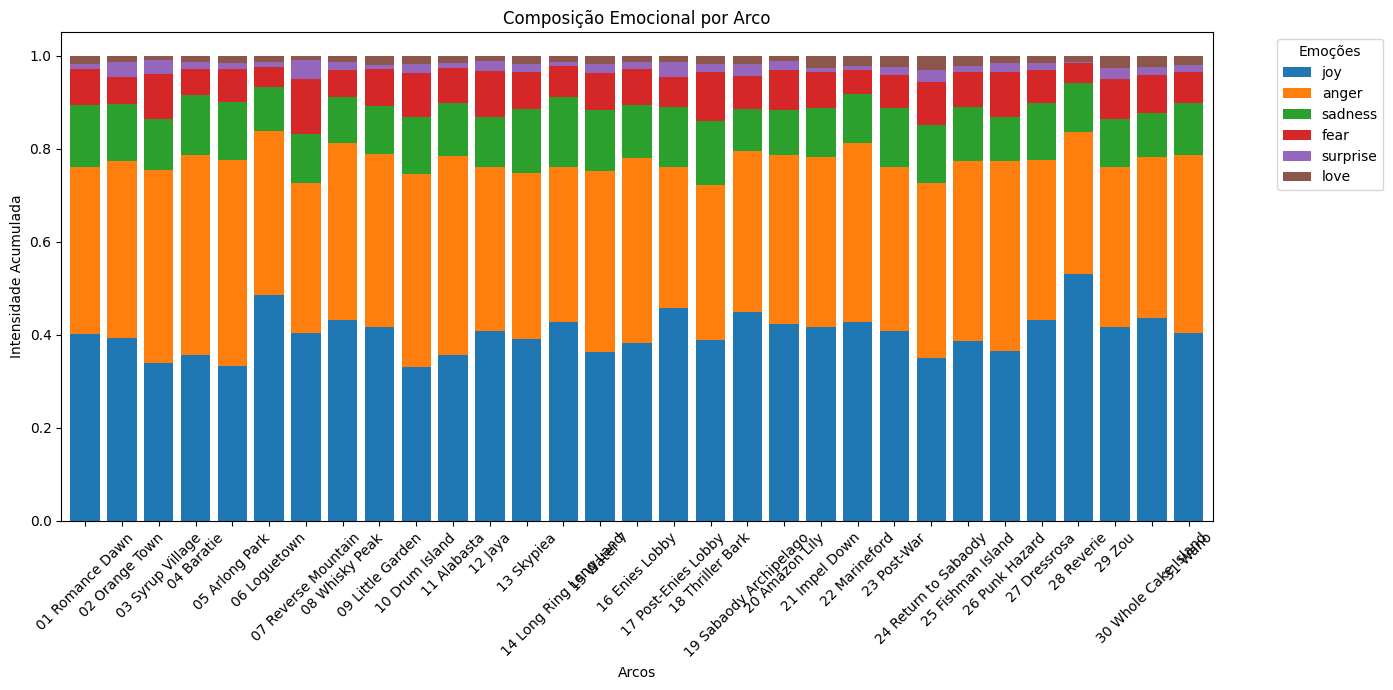

In [469]:
# cópia para garantir que a ordenação não afete outros usos
df_plot = df_arc_emotions.set_index('arc')

# Ordenar emoções por intensidade média
sorted_emotions = df_plot[emotion_labels].mean().sort_values(ascending=False).index

# plotagem
df_plot[sorted_emotions].plot(
    kind='bar', 
    stacked=True, 
    figsize=(14, 7),
    width=0.8
)

plt.title('Composição Emocional por Arco')
plt.ylabel('Intensidade Acumulada')
plt.xlabel('Arcos')
plt.legend(title='Emoções', bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

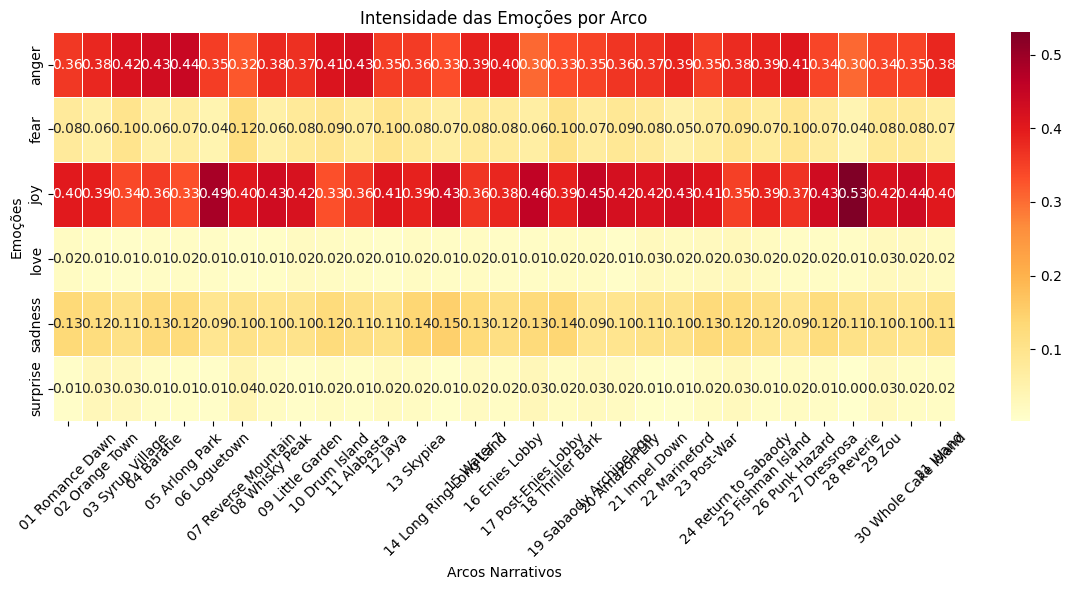

In [467]:
import seaborn as sns

# Preparar dados (transpor as emoções)
heatmap_data = df_arc_emotions.set_index('arc')[emotion_labels].T

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, 
            annot=True, 
            cmap="YlOrRd", 
            fmt=".2f",
            linewidths=.5)
plt.title('Intensidade das Emoções por Arco')
plt.ylabel('Emoções')
plt.xlabel('Arcos Narrativos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

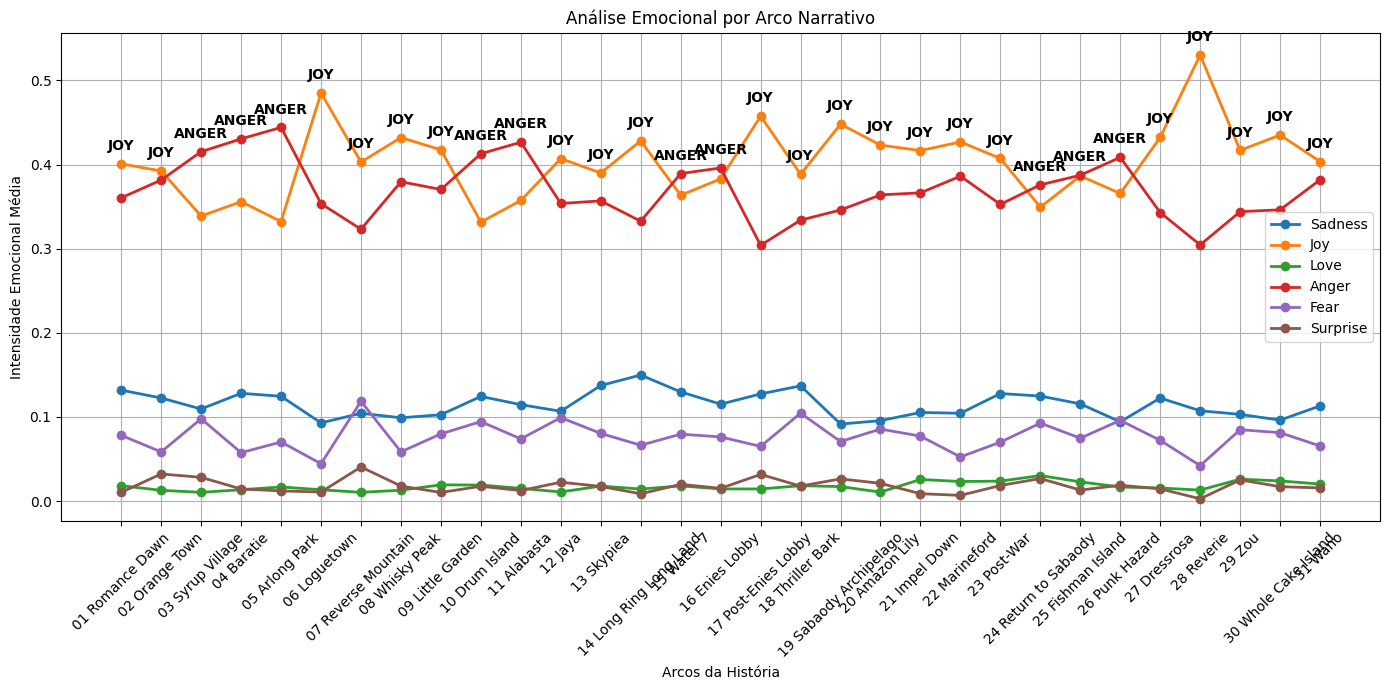

In [472]:
# 4. Visualização
emotion_labels = [col for col in df_arc_emotions.columns if col not in ['arc', 'dominant_emotion']]
df_plot = df_arc_emotions.sort_values('arc')

plt.figure(figsize=(14, 7))
for emotion in emotion_labels:
    plt.plot(df_plot['arc'], df_plot[emotion], 
             marker='o', 
             linestyle='-', 
             linewidth=2,
             label=emotion.capitalize())

for idx, row in df_plot.iterrows():
    plt.annotate(row['dominant_emotion'].upper(), 
                xy=(row['arc'], row[row['dominant_emotion']]),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center',
                weight='bold')

plt.xlabel('Arcos da História')
plt.ylabel('Intensidade Emocional Média')
plt.title('Análise Emocional por Arco Narrativo')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()